In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
from information import *
from processing import *
from variance import *
from plotting import *
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

In [3]:
plt.rcParams['hatch.color'] = 'tab:blue'

### Predictability in the high-latitude oceans

In [4]:
frequency = 'monthly'
grid = xr.open_dataset(ppeDict['griddirtmp']+ppeDict['gridfile'])
smooth = 12
startmonth = 1

In [5]:
masks = generate_masks(grid)
### LME mask
LMEmasks = xr.open_dataset(ppeDict['pathLMEmask'])

In [6]:
### Load time horizon
savedir = ppeDict['datasavedir']+'/processed/ppp_timehorizon/'
savenames = ['*',frequency,str(startmonth).zfill(2)]
if smooth is not None:
    savenames.append('smooth_'+str(smooth))
filename = '.'.join([*savenames,'nc'])
ds_th = xr.open_mfdataset(savedir+filename)

In [7]:
print(ds_th.data_vars)

Data variables:
    MLD_003  (yh, xh) int64 dask.array<chunksize=(576, 720), meta=np.ndarray>
    chlos    (yh, xh) int64 dask.array<chunksize=(576, 720), meta=np.ndarray>
    intpp    (yh, xh) int64 dask.array<chunksize=(576, 720), meta=np.ndarray>
    no3os    (yh, xh) int64 dask.array<chunksize=(576, 720), meta=np.ndarray>
    o2os     (yh, xh) int64 dask.array<chunksize=(576, 720), meta=np.ndarray>
    phos     (yh, xh) int64 dask.array<chunksize=(576, 720), meta=np.ndarray>
    phycos   (yh, xh) int64 dask.array<chunksize=(576, 720), meta=np.ndarray>
    po4os    (yh, xh) int64 dask.array<chunksize=(576, 720), meta=np.ndarray>
    sos      (yh, xh) int64 dask.array<chunksize=(576, 720), meta=np.ndarray>
    tos      (yh, xh) int64 dask.array<chunksize=(576, 720), meta=np.ndarray>
    zoocos   (yh, xh) int64 dask.array<chunksize=(576, 720), meta=np.ndarray>


In [8]:
### Load climatological sea-ice and minimum nutrients
def preprocess(ds):
    if 'xT' in ds.dims:
        return ds.rename({'xT':'xh','yT':'yh'})
    else:
        return ds
savedir = ppeDict['datasavedir']+'/processed/climatology/seasonal/'
ds_seas = xr.open_mfdataset(savedir+'*.monthly.nc',preprocess=preprocess)
savedir = ppeDict['datasavedir']+'/processed/climatology/meanannualmin/'
ds_annmin = xr.open_mfdataset(savedir+'*.monthly.nc',preprocess=preprocess)
savedir = ppeDict['datasavedir']+'/processed/climatology/meanannualmax/'
ds_annmax = xr.open_mfdataset(savedir+'*.monthly.nc',preprocess=preprocess)

In [9]:
ds_annmin

<xarray.Dataset>
Dimensions:  (xh: 720, yh: 576)
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
Data variables:
    chlos    (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dfeos    (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    intpp    (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    no3os    (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    po4os    (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>

In [10]:
pole_kwargs = {'north':{'projection':ccrs.NorthPolarStereo(),'mult':1,'imonthsimin':8,'imonthsimax':3,'po4osmin':1e-5,'no3osmin':1e-4,'dfemin':6e-8},
                'south':{'projection':ccrs.SouthPolarStereo(),'mult':-1,'imonthsimin':3,'imonthsimax':8,'po4osmin':1e-5,'no3min':1e-4,'dfemin':6e-8}}
nutrient_kwargs = {'po4os':{'min':1e-5,'cmap':'Blues','longname':'PO4'},
                   'no3os':{'min':1e-4,'cmap':'Purples','longname':'NO3'},
                   'dfeos':{'min':5e-8,'cmap':'Greens','longname':'dFe'}}

In [11]:
def plot_PolarStereographic(pole,**kwargs):
    
    crsP = kwargs['projection']

    mult = kwargs['mult']
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crsP})

    ax.add_feature(cfeature.LAND,facecolor='darkgray')
    ax.set_extent([-180, 180, mult*90, mult*55], ccrs.PlateCarree())

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    return fig,ax

### Time horizon

In [19]:
variable = 'intpp'
pole = 'south'
nutrients = ['no3os','po4os','dfeos']

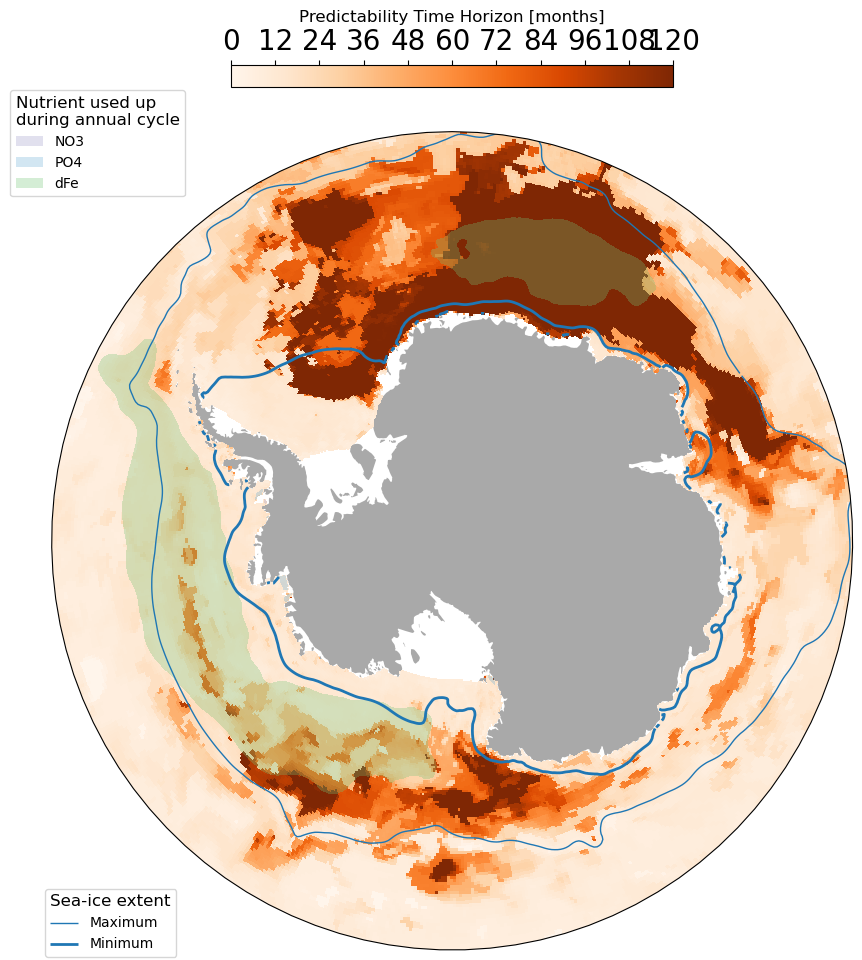

In [71]:
X = grid['geolon']
Y = grid['geolat']
Z = ds_th[variable].where(masks['global'])
Zsi = ds_seas['siconc']
cmap = 'Oranges'

fig,ax = plot_PolarStereographic(pole,**pole_kwargs[pole])

crsT = ccrs.PlateCarree()
im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crsT,shading='auto')
cbar = plt.colorbar(im,orientation='horizontal',location='top',fraction=0.025,pad=0.05)
cbar.set_label('Predictability Time Horizon [months]',fontsize=12)
cbar.set_ticks(np.arange(0,121,12))

Zsinow = Zsi.sel(month=pole_kwargs[pole]['imonthsimax'])
csi = ax.contour(X,Y,Zsinow,levels=[0.15],transform=crsT,colors='tab:blue',linewidths=1)
artists_simax,labels = csi.legend_elements()
Zsinow = Zsi.sel(month=pole_kwargs[pole]['imonthsimin'])
csi = ax.contour(X,Y,Zsinow,levels=[0.15],transform=crsT,colors='tab:blue',linewidths=2)
artists_simin,labels = csi.legend_elements()

legend_si = ax.legend([artists_simax[0], artists_simin[0]], ["Maximum", "Minimum"],
                        loc = 'lower left',
                        title = 'Sea-ice extent',
                        alignment = 'left',
                        title_fontsize = 12,
                        fontsize=10,
                        borderaxespad=-0.5)

artists=[]
labels=[]
for nutrient in nutrients:
    Znow = ds_annmin[nutrient]
    cs = ax.contourf(X,Y,Znow,
                     levels=[0,nutrient_kwargs[nutrient]['min']],
                     cmap=nutrient_kwargs[nutrient]['cmap'],
                     alpha=0.3,
                     transform=crsT)
    artist, label = cs.legend_elements()
    artists.append(artist[0])
    labels.append(nutrient_kwargs[nutrient]['longname'])

if pole=='north':
    for region in LMEArctic:
        ax.contour(X,Y,LMEmasks[region].transpose(),levels = [0.5],colors='black',linewidths=0.5,transform=crsT,alpha=0.3)


ax.legend(artists,labels,
          loc='upper left',
          title='Nutrient used up\nduring annual cycle',
          alignment='left',
          title_fontsize = 12,
          fontsize=10,
          borderaxespad=-3)


ax.add_artist(legend_si)

fig.tight_layout()

savefile = '.'.join(['ppp_timehorizon',variable,pole,'png'])
fig.savefig(ppeDict['figsavedir']+'/highlats/'+savefile,dpi=300,transparent=True)

### Climatologies

In [125]:
variable = 'dfeos'
pole = 'south'

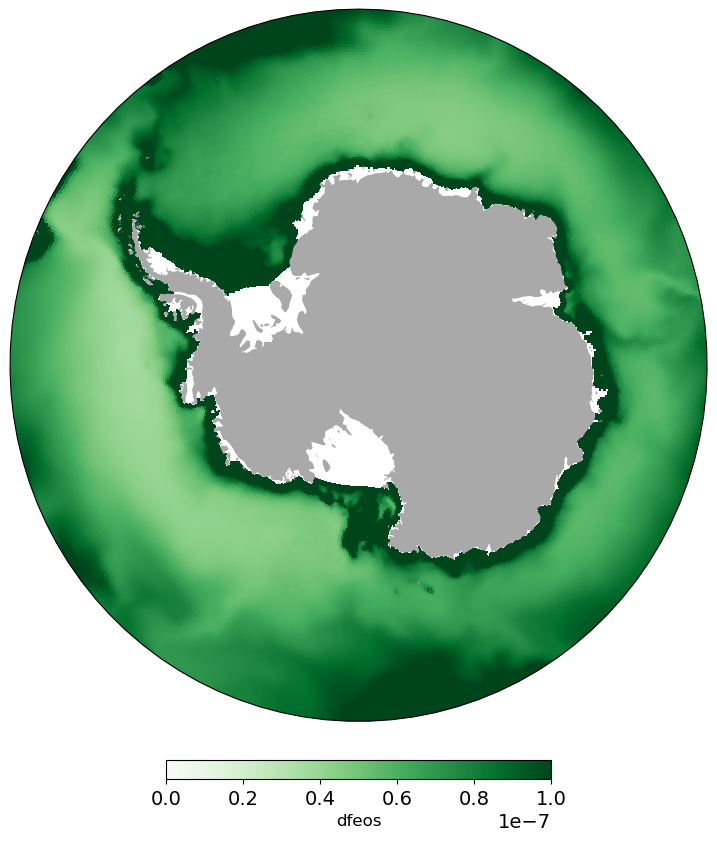

In [126]:
X = grid['geolon']
Y = grid['geolat']
Z = ds_annmin[variable].where(masks['global'])
cmap = 'Greens'

fig,ax = plot_PolarStereographic(pole,**pole_kwargs[pole])

crsT = ccrs.PlateCarree()
im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crsT,shading='auto')
im.set_clim([0,1e-7])
cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
cbar.set_label(variable,fontsize=12)

### LMEs

In [21]:
metric = 'ppp'
comparison = 'e2c'
mc = '.'.join([metric,comparison])
savedir = ppeDict['datasavedir']+'/processed/skill_regionalmeans/'+mc+'/'
frequency = 'monthly'
startmonth = 1
maskset = 'LME'
filename = '.'.join(['*',frequency,str(startmonth).zfill(2),maskset,'nc'])
ds_lme = xr.open_mfdataset(savedir+filename).sel(region = LMEArctic).transpose()
ds_lme.data_vars

Data variables:
    MLD_003  (region, time) float64 dask.array<chunksize=(17, 120), meta=np.ndarray>
    chlos    (region, time) float64 dask.array<chunksize=(17, 120), meta=np.ndarray>
    intpp    (region, time) float64 dask.array<chunksize=(17, 120), meta=np.ndarray>
    no3os    (region, time) float64 dask.array<chunksize=(17, 120), meta=np.ndarray>
    o2os     (region, time) float64 dask.array<chunksize=(17, 120), meta=np.ndarray>
    phos     (region, time) float64 dask.array<chunksize=(17, 120), meta=np.ndarray>
    phycos   (region, time) float64 dask.array<chunksize=(17, 120), meta=np.ndarray>
    po4os    (region, time) float64 dask.array<chunksize=(17, 120), meta=np.ndarray>
    siconc   (region, time) float64 dask.array<chunksize=(17, 120), meta=np.ndarray>
    sos      (region, time) float64 dask.array<chunksize=(17, 120), meta=np.ndarray>
    tos      (region, time) float64 dask.array<chunksize=(17, 120), meta=np.ndarray>
    zoocos   (region, time) float64 dask.array<ch

In [22]:
variable = 'intpp'
da = ds_lme[variable]
mask = (da>ppp_threshold)
cname = 'Potential Prognostic Predictability'
hatch = '///'
ma = np.ma.masked_where(mask,da)

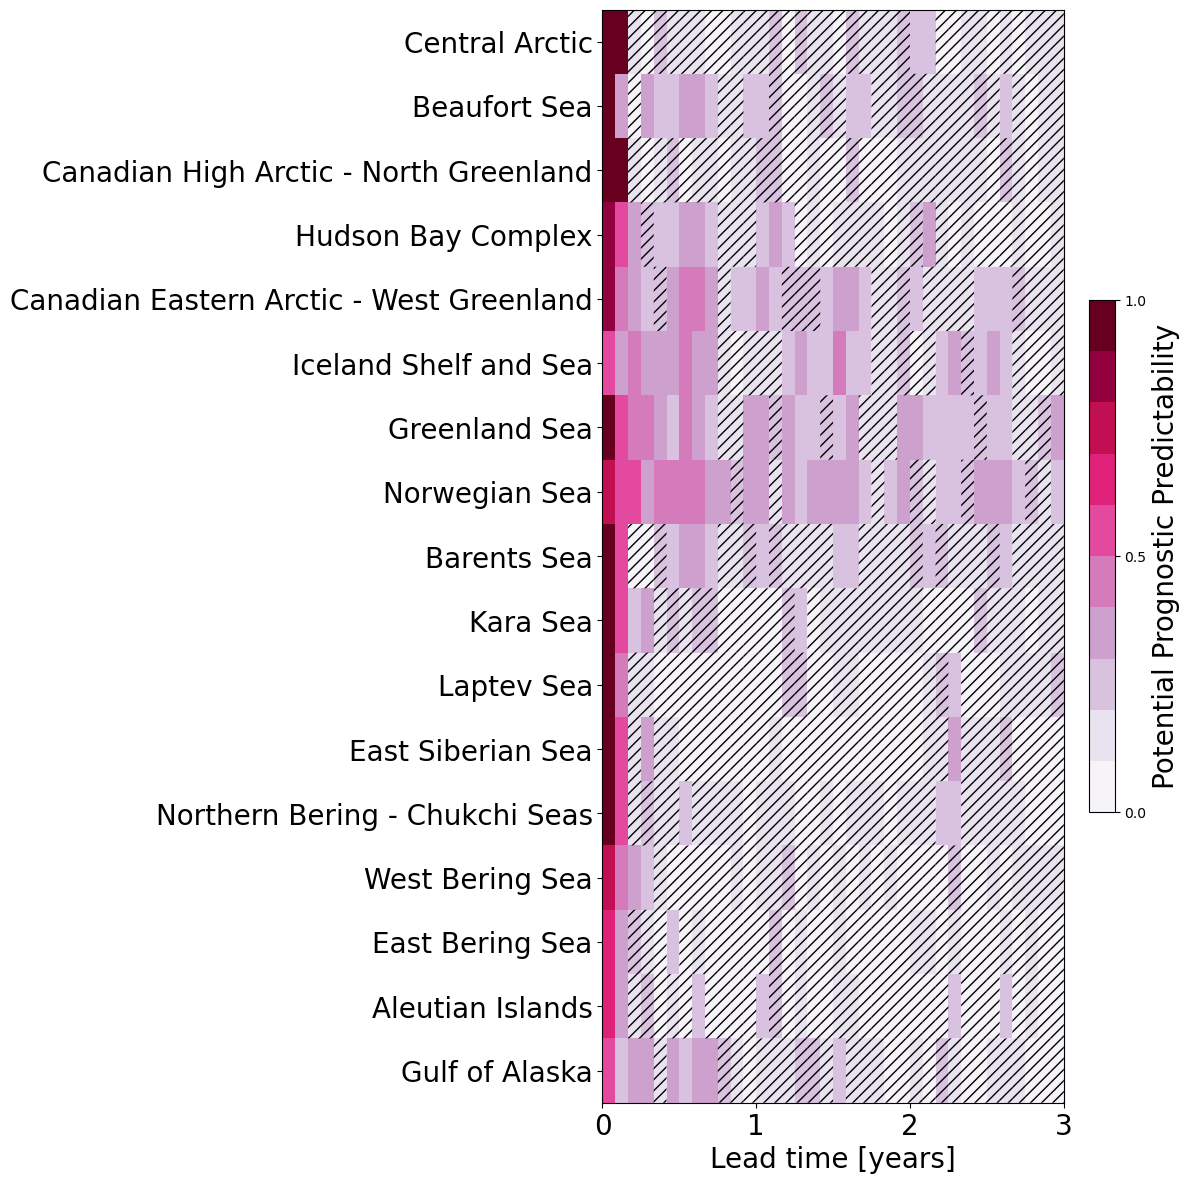

In [41]:
plt.rcParams['hatch.color'] = 'black'

fig,ax = plt.subplots(figsize=(12,12))
im = ax.pcolormesh(da)
ax.pcolor(ma,hatch=hatch,alpha=0)
im.set_clim([0,1])
im.set_cmap(mpl.colormaps['PuRd'].resampled(10))

ax.set_xlim([0,36])
ax.set_xlabel('Lead time [years]',fontsize=20)
ax.set_xticks(np.arange(0,37,12))
ax.set_xticklabels(np.arange(4),fontsize=20)
ax.set_yticks(np.arange(len(ds_lme['region']))+0.5)
ax.set_yticklabels(ds_lme['region'].values,fontsize=20);

cb = plt.colorbar(im,ax=ax,orientation='vertical',location='right',fraction=0.05,pad=0.05)
cb.set_label(cname,fontsize=20)
cb.set_ticks([0,0.5,1])

plt.tight_layout()

savefile = '.'.join(['ppp_LMEArctic','png'])
fig.savefig(ppeDict['figsavedir']+'/highlats/'+savefile,dpi=300,transparent=True)

In [59]:
def draw_ppp_regionalmeans(ds,colors=None,longnames=None):
    threshold = 0.235559205
    fig,ax=plt.subplots(figsize=(16,4))
    lines = {}
    for i,(name,da) in enumerate(ds.items()):
        line, = ax.plot(da['time']+0.5,da,label=name)
        lines[name]=line;
        if colors is not None:
            lines[name].set_color(colors[name])
        if longnames is not None:
            lines[name].set_label(longnames[name])
    ax.legend(frameon=False)
    ax.set_xlabel('Lead time (months)')
    ax.set_ylabel('PPP')
    ax.set_xlim([0,da['time'].max()])
    ax.set_ylim([0,1])
    ax.axhline(threshold,linestyle='--',color='gray')
    return fig,ax,lines

In [60]:
variables = ['tos','MLD_003','po4os','no3os','chlos','intpp']
colors = {'intpp':'tab:green',
          'chlos':'tab:green',
          'tos':'tab:blue',
          'po4os':'tab:orange',
          'no3os':'tab:red',
          'MLD_003':'tab:purple',
         'siconc':'tab:cyan'}
longnames = {'intpp':'Depth-integrated NPP',
             'chlos':'Chl-a (surface)',
              'tos':'SST',
              'po4os':'PO4 (surface)',
              'no3os':'NO3 (surface)',
              'MLD_003':'MLD',
             'siconc':'Sea-ice Concentration'}
regions = ['Central Arctic',
           'Norwegian Sea',
           'Canadian Eastern Arctic - West Greenland',
           'Barents Sea']

In [61]:
mpl.rcParams['font.size']=20

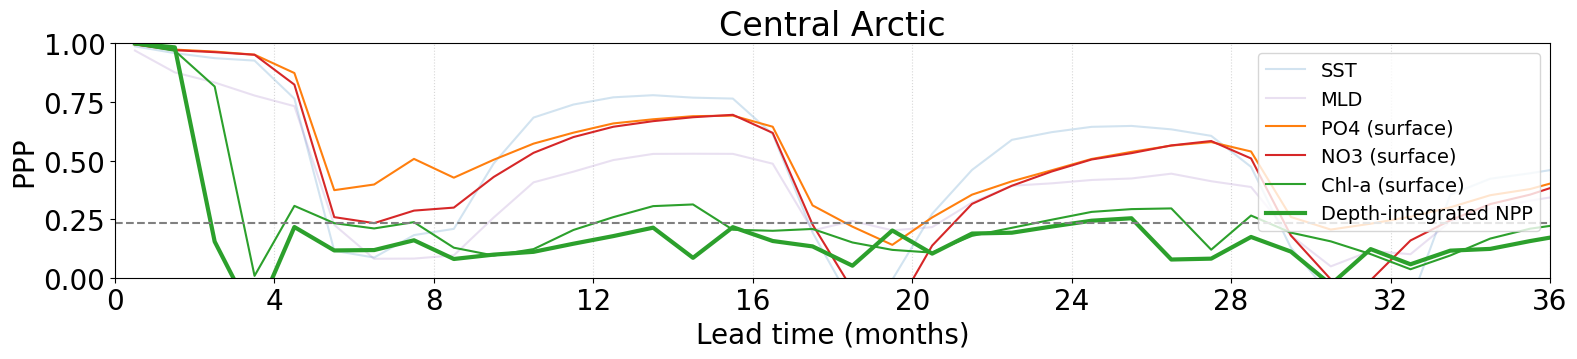

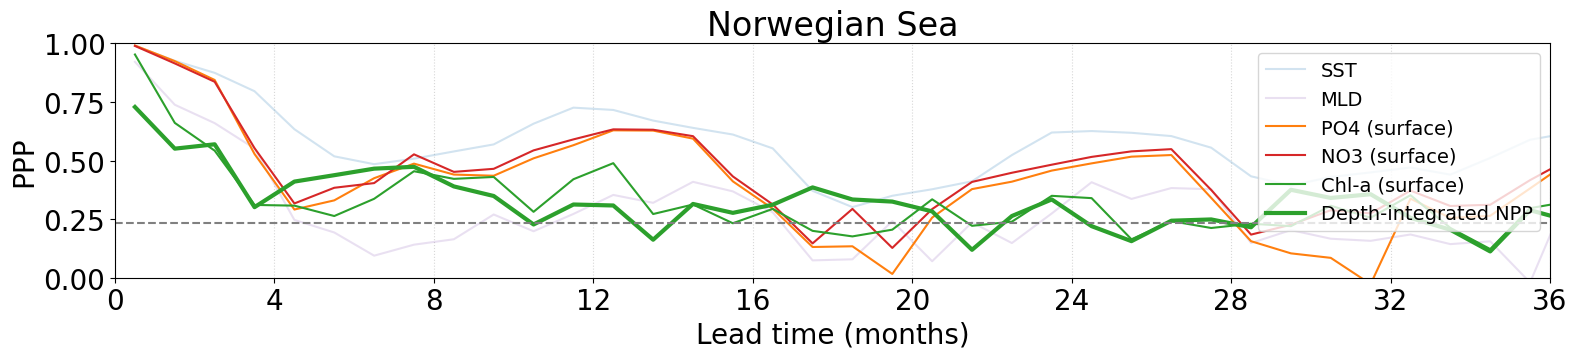

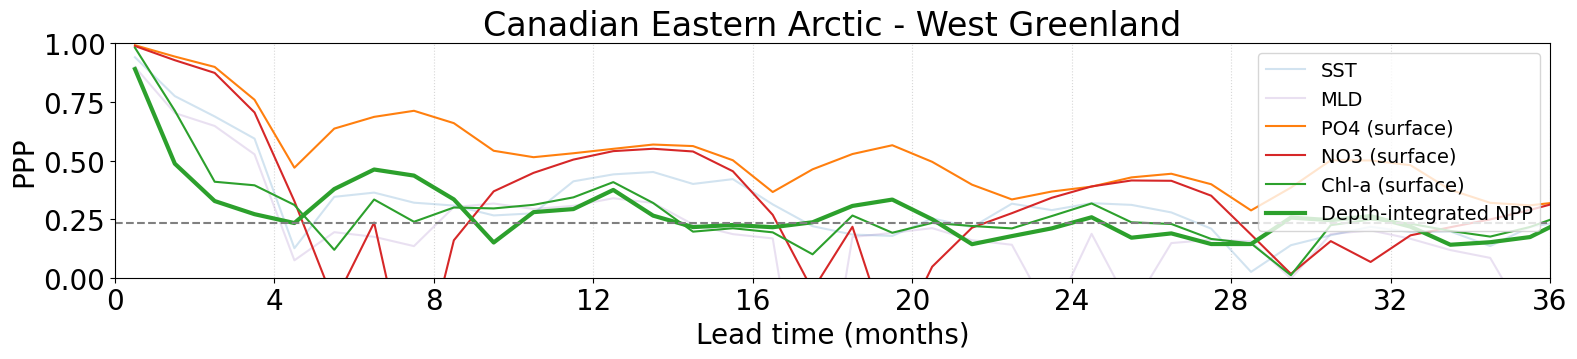

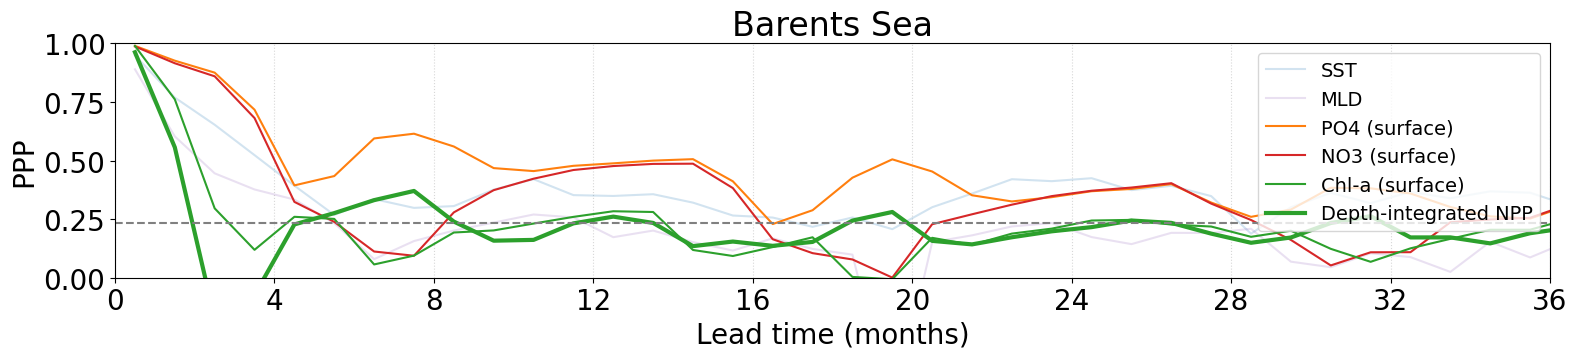

In [66]:
for region in regions:
    fig,ax,lines = draw_ppp_regionalmeans(ds_lme[variables].sel(region=region),colors=colors,longnames=longnames)
    ax.set_title(region)
    ax.set_xlim([0,36])
    ax.set_xticks(np.arange(0,37,4))
    lines['intpp'].set_linewidth(3)
    lines['tos'].set_alpha(0.2)
    lines['MLD_003'].set_alpha(0.2)
    ax.legend(fontsize=14,loc='upper right')
    ax.grid(axis='x',linestyle=':',alpha=0.5)
    fig.tight_layout()
    savefile = '.'.join(['ppp_timeseries',region,'png'])
    fig.savefig(ppeDict['figsavedir']+'/highlats/'+savefile,dpi=300,transparent=True)

In [76]:
find_ppp('dfeos','monthly',1)